In [3]:
import glob
import os
import sys

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla
import random
import cv2
import skimage.measure as measure

#in synchronous mode, sensor data must be added to a queue
import queue


In [4]:
client = carla.Client('localhost', 2000)
client.set_timeout(11.0)

In [5]:
print(client.get_available_maps())

['/Game/Carla/Maps/Town02', '/Game/Carla/Maps/Town01', '/Game/Carla/Maps/Town03', '/Game/Carla/Maps/Town04', '/Game/Carla/Maps/Town05']


In [6]:
world = client.load_world('Town03')
settings = world.get_settings()
settings.fixed_delta_seconds = 0.05 #must be less than 0.1, or else physics will be noisy
#must use fixed delta seconds and synchronous mode for python api controlled sim, or else 
#camera and sensor data may not match simulation properly and will be noisy 
settings.synchronous_mode = True 
world.apply_settings(settings)

55211

In [7]:
weather = carla.WeatherParameters(
    cloudiness=20.0,
    precipitation=20.0,
    sun_altitude_angle=110.0)

#or use precomputed weathers
#weather = carla.WeatherParameters.WetCloudySunset

world.set_weather(weather)


In [35]:
blueprints = world.get_blueprint_library().filter('*')
for blueprint in blueprints:
    print(blueprint.id)
    for attr in blueprint:
       print('  - {}'.format(attr))


vehicle.audi.a2
  - ActorAttribute(id=number_of_wheels,type=int,value=4(const))
  - ActorAttribute(id=sticky_control,type=bool,value=True)
  - ActorAttribute(id=object_type,type=str,value=(const))
  - ActorAttribute(id=color,type=Color,value=Color(224,0,0,255))
  - ActorAttribute(id=role_name,type=str,value=autopilot)
vehicle.mercedes-benz.coupe
  - ActorAttribute(id=number_of_wheels,type=int,value=4(const))
  - ActorAttribute(id=sticky_control,type=bool,value=True)
  - ActorAttribute(id=object_type,type=str,value=(const))
  - ActorAttribute(id=color,type=Color,value=Color(183,187,162,255))
  - ActorAttribute(id=role_name,type=str,value=autopilot)
static.prop.shoppingtrolley
  - ActorAttribute(id=size,type=str,value=small(const))
  - ActorAttribute(id=role_name,type=str,value=prop)
controller.ai.walker
  - ActorAttribute(id=role_name,type=str,value=default)
vehicle.bmw.grandtourer
  - ActorAttribute(id=number_of_wheels,type=int,value=4(const))
  - ActorAttribute(id=sticky_control,type=

In [8]:
actor_list = []

blueprint_library = world.get_blueprint_library()
bp = random.choice(blueprint_library.filter('vehicle')) # lets choose a vehicle at random

# lets choose a random spawn point
transform = random.choice(world.get_map().get_spawn_points()) 

#spawn a vehicle
vehicle = world.spawn_actor(bp, transform)
actor_list.append(vehicle)

vehicle.set_autopilot(True)


#lets create waypoints for driving the vehicle around automatically
m= world.get_map()
waypoint = m.get_waypoint(transform.location)

#lets add more vehicles
for _ in range(0, 200):
    transform = random.choice(m.get_spawn_points())

    bp = random.choice(blueprint_library.filter('vehicle'))

    # This time we are using try_spawn_actor. If the spot is already
    # occupied by another object, the function will return None.
    npc = world.try_spawn_actor(bp, transform)
    if npc is not None:
        #print(npc)
        npc.set_autopilot(True)
        actor_list.append(npc)
        

In [9]:


#example for getting camera image
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
image_queue = queue.Queue()
camera.listen(image_queue.put)
actor_list.append(camera)

#example for getting depth camera image
camera_depth = blueprint_library.find('sensor.camera.depth')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera_d = world.spawn_actor(camera_depth, camera_transform, attach_to=vehicle)
image_queue_depth = queue.Queue()
camera_d.listen(image_queue_depth.put)
actor_list.append(camera_d)

#example for getting semantic segmentation camera image
camera_semseg = blueprint_library.find('sensor.camera.semantic_segmentation')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera_seg = world.spawn_actor(camera_semseg, camera_transform, attach_to=vehicle)
image_queue_seg = queue.Queue()
camera_seg.listen(image_queue_seg.put)
actor_list.append(camera_seg)



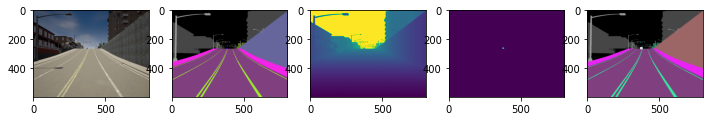

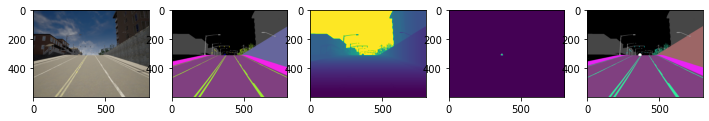

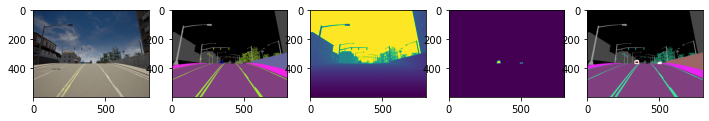

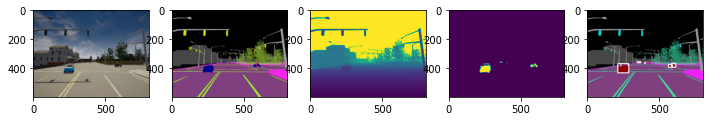

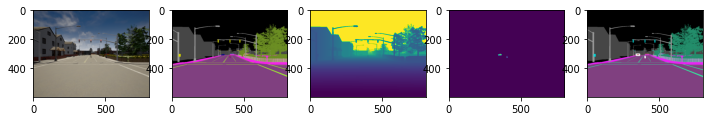

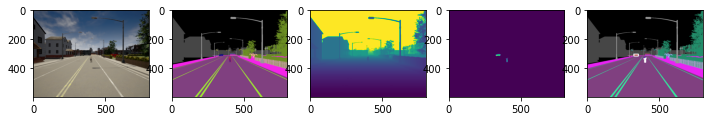

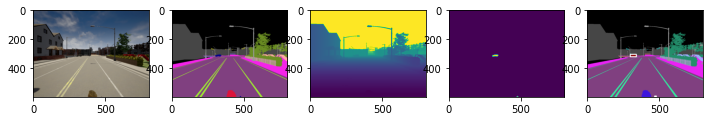

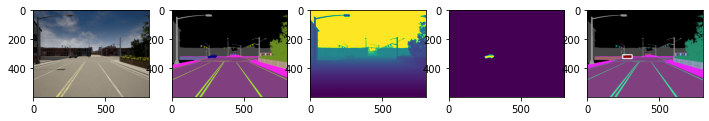

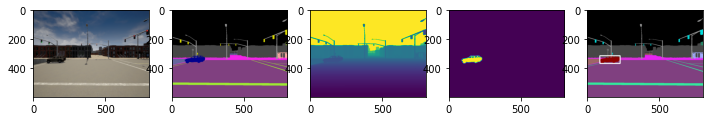

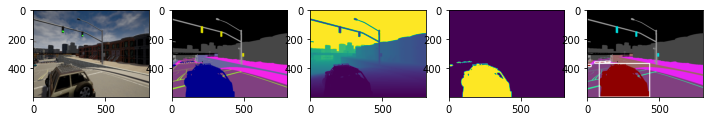

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#from detectron2.structures import BoxMode
import pycocotools

def get_mask(seg_im, rgb_value):
    # rgb_value should be somethiing like np.uint8([[[70, 70, 70]]])
    # seg_im should be in HSV
    
    hsv_value = cv2.cvtColor(rgb_value, cv2.COLOR_RGB2HSV)
    
    hsv_low = np.array([[[hsv_value[0][0][0]-5, hsv_value[0][0][1], hsv_value[0][0][2]-5]]])
    hsv_high = np.array([[[hsv_value[0][0][0]+5, hsv_value[0][0][1], hsv_value[0][0][2]+5]]])
    
    mask = cv2.inRange(seg_im, hsv_low, hsv_high)
    return mask

def get_bbox_from_mask(mask):
    label_mask = measure.label(mask)
    props = measure.regionprops(label_mask)
    
    return [prop.bbox for prop in props]
    

#in sychronous mode, client controls step of simulation and number of steps
dataset_dicts = []
global_count=0
for i in range(100):
    #step
    world.tick()

    #rgb camera
    image = image_queue.get()

    #semantic segmentation camera
    image_seg  = image_queue_seg.get()
    #image_seg.convert(carla.ColorConverter.CityScapesPalette)

    #depth camera
    image_depth = image_queue_depth.get()
    #image_depth.convert(carla.ColorConverter.LogarithmicDepth)
    
    
    if i%10==0:
        image.save_to_disk("test_images/%06d.png" %(image.frame))
        image_seg.save_to_disk("test_images/%06d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette)
        image_depth.save_to_disk("test_images/%06d_depth.png" %(image.frame), carla.ColorConverter.LogarithmicDepth)

        img = mpimg.imread("test_images/%06d.png" % image.frame)
        img_semseg = mpimg.imread("test_images/%06d_semseg.png" % image.frame)
        img_depth = mpimg.imread("test_images/%06d_depth.png" % image.frame)
        
        ## COCO format stuff, each image needs to have these keys
        height, width = cv2.imread("test_images/%06d.png" %(image.frame)).shape[:2]
        record = {}
        record['file_name'] = "test_images/%06d.png" %(image.frame)
        global_count+=1
        record['image_id'] = global_count
        record['height'] = height
        record['width'] = width
        
        
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (12,18))
        ax1.imshow(img)
        ax2.imshow(img_semseg)
        ax3.imshow(img_depth)
        
        
        ## compute bboxes from semseg
        img_semseg_bgr = cv2.imread("test_images/%06d_semseg.png" % image.frame)
        img_semseg_bgr = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGRA2BGR)
        img_semseg_hsv = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGR2HSV) # color wise segmentation is better in hsv space

        #bgr value exmaples of few objects: full list at https://carla.readthedocs.io/en/0.9.9/ref_sensors/ 
        object_list = dict()
        object_list['building'] = np.uint8([[[70, 70, 70]]])        
        object_list['pedestrian'] = np.uint8([[[220, 20, 60]]])
        object_list['vegetation'] = np.uint8([[[107, 142, 35]]])
        object_list['car'] = np.uint8([[[ 0, 0, 142]]])
        object_list['fence'] = np.uint8([[[ 190, 153, 153]]])
        object_list['traffic_sign'] = np.uint8([[[220, 220, 0]]])
        object_list['pole'] = np.uint8([[[153, 153, 153]]])
        object_list['wall'] = np.uint8([[[102, 102, 156]]])
        
        object_bboxes = dict()
        objects = []
        obj_id = 0
        obj2id = dict()
        for obj in object_list:
            mask = get_mask(img_semseg_hsv, object_list[obj])
            bboxes = get_bbox_from_mask(mask)
            object_bboxes[obj] = bboxes
            
            #let's visualize car bboxes
            if obj=='car':
                ax4.imshow(mask)
                for bbox in bboxes:
                    minr, minc, maxr, maxc = bbox
                    cv2.rectangle(img_semseg_bgr, (minc,minr), (maxc, maxr), (255,255,255), 6)
        
                ax5.imshow(img_semseg_bgr)
            
            #lets put things in coco format for finetuning mask rcnn
            for bbox in bboxes:
                minr, minc, maxr, maxc = bbox
                obj_mask = np.copy(mask)
                obj_mask[:minr] = 0
                obj_mask[:, :minc] = 0
                obj_mask[maxr+1:] = 0
                obj_mask[:, maxc+1:] = 0

                #coco_rle_mask = pycocotools.mask.encode(np.array(obj_mask, order="F"))
                
                obj_ann = {
                        'bbox': [minc, minr, maxc, maxr],
                        #'bbox_mode': BoxMode.XYXY_ABS,
                        #'segmentation': coco_rle_mask,
                        'category_id': obj_id
                }
                objects.append(obj_ann)
                
                obj_id+=1
                obj2id[obj] = obj_id
            
        record['annotations'] = objects
        
        #print(record)
        
        dataset_dicts.append(record)
                
            
        plt.show()
    
    #drive vehicle to next waypoint on map
    waypoint = random.choice(waypoint.next(1.5))
    vehicle.set_transform(waypoint.transform)
    

In [11]:
#make sure to destroy all cameras and actors since they remain in the simulator even if you respawn using python. 
#It gets destroyed only if you restart CARLA simulator
camera.destroy()
camera_d.destroy()
camera_seg.destroy()
client.apply_batch([carla.command.DestroyActor(x) for x in actor_list])

True